In [ ]:
from loglizer.models import *
from loglizer import dataloader, preprocessing, utils
from imblearn.over_sampling import SMOTE, RandomOverSampler
import pandas as pd

supervised = ['LR', 'SVM', 'DecisionTree']
unsupervised = ['InvariantsMiner','PCA', 'IsolationForest']
semi_supervised = ['LogClustering']

#Load data
label_file = 'data/HDFS/anomaly_label.csv'
datasets = ['HDFS.npz', 'HDFS_0.25.npz', 'HDFS_0.5.npz', 'HDFS_0.75.npz', 'HDFS_0.99.npz', 'HDFS_0.999.npz', 'HDFS_0.9998.npz']
train_ratios = [0.5, 0.75, 0.9]

dfs = []

for dataset in datasets:
    for train_ratio in train_ratios:
        print('DATASET', dataset, 'TRAINING RATIO', train_ratio)
        
        #Split data
        (x_tr, y_train), (x_te, y_test) = dataloader.load_HDFS('data/HDFS/' + dataset,
                                                                [],
                                                                label_file=label_file,
                                                                window='session', 
                                                                train_ratio=train_ratio,
                                                                split_type='uniform')
        
    
        
        for _model in supervised + unsupervised + semi_supervised:
            print('-'*30,'CURRENTLY:', _model,'-'*30)
            #If model is supervised, generate new samples by randomly sampling with replacement the current available samples to balance both classes.
            if(_model in supervised):
                #Oversample anomalies
                feature_extractor = preprocessing.FeatureExtractor()
                x_train = feature_extractor.fit_transform(x_tr, term_weighting='tf-idf')
                sm = RandomOverSampler(random_state=2)
                x_train_sm, y_train_sm = sm.fit_sample(x_train, y_train)

                if(_model == 'SVM'):
                    model = SVM()
                elif(_model == 'DecisionTree'):
                    model = DecisionTree()
                else:
                    model = LR()
                    
                model.fit(x_train, y_train)
            else:
                if _model == 'PCA':
                    feature_extractor = preprocessing.FeatureExtractor()
                    x_train = feature_extractor.fit_transform(x_tr, term_weighting='tf-idf', 
                                                              normalization='zero-mean')
                    model = PCA()
                    model.fit(x_train)

                elif _model == 'InvariantsMiner':
                    feature_extractor = preprocessing.FeatureExtractor()
                    x_train = feature_extractor.fit_transform(x_tr)
                    #model = InvariantsMiner(epsilon=0.5)
                    model = InvariantsMiner(epsilon=0.001)
                    model.fit(x_train)

                elif _model == 'LogClustering':
                    feature_extractor = preprocessing.FeatureExtractor()
                    x_train = feature_extractor.fit_transform(x_tr, term_weighting='tf-idf')
                    model = LogClustering(max_dist=0.3, anomaly_threshold=0.3)
                    model.fit(x_train[y_train == 0, :]) # Use only normal samples for training

                elif _model == 'IsolationForest':
                    feature_extractor = preprocessing.FeatureExtractor()
                    x_train = feature_extractor.fit_transform(x_tr)
                    model = IsolationForest(random_state=2019, max_samples=0.9999, contamination=0.03, 
                                            n_jobs=4)
                    model.fit(x_train)

            x_test = feature_extractor.transform(x_te)
            print('Train accuracy:')
            
            if(_model in supervised):
                precision, recall, f1_train, mcc, roc_auc, tn, fp, fn, tp = model.evaluate(x_train_sm, y_train_sm)
            else:
                precision, recall, f1_train, mcc, roc_auc, tn, fp, fn, tp = model.evaluate(x_train, y_train)
            
            print('Test accuracy:')
            precision, recall, f1, mcc, roc_auc, tn, fp, fn, tp = model.evaluate(x_test, y_test)

            results = [('model_name', _model), ('model', model), ('f1-train', f1_train), ('f1-test', f1), ('train_ratio', train_ratio),  ('reduction', dataset.split('.npz')[0].split('_')[-1])]
            dfs.append(pd.DataFrame({x[0]:x[1:] for x in results}))

DATASET HDFS.npz TRAINING RATIO 0.5
====== Input data summary ======
Total: 575061 instances, 16838 anomaly, 558223 normal
Train: 287530 instances, 8419 anomaly, 279111 normal
Test: 287531 instances, 8419 anomaly, 279112 normal

------------------------------ CURRENTLY: LR ------------------------------
====== Transformed train data summary ======
Train data shape: 287530-by-29

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 287531-by-29

Train accuracy:
====== Evaluation summary ======
Precision: 0.999, recall: 0.953, F1-measure: 0.975

MCC: 0.9524701001126805
ROC AUC: 0.9757318772817982
Test accuracy:
====== Evaluation summary ======
Precision: 0.955, recall: 0.952, F1-measure: 0.954

MCC: 0.9525175677516408
ROC AUC: 0.9755724361877705
------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 287530-by-29

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


====== Transformed test data summary ======
Test data shape: 287531-by-29

Train accuracy:
====== Evaluation summary ======
Precision: 0.999, recall: 0.969, F1-measure: 0.984

MCC: 0.9686650653548075
ROC AUC: 0.9841228041890144
Test accuracy:
====== Evaluation summary ======
Precision: 0.959, recall: 0.970, F1-measure: 0.965

MCC: 0.9636947335453196
ROC AUC: 0.9845310166914201
------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 287530-by-29

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 287531-by-29

Train accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 0.999, F1-measure: 1.000

MCC: 0.9994196941615581
ROC AUC: 0.9997097928781024
Test accuracy:
====== Evaluation summary ======
Precision: 0.998, recall: 0.998, F1-measure: 0.998

MCC: 0.9977974886168696
ROC AUC: 0.9988987443084348
------------------------------ CURRENTLY: Invaria

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 287531-by-29

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.831, recall: 0.769, F1-measure: 0.799

MCC: 0.7934007450558598
ROC AUC: 0.8819518153770481
Test accuracy:
====== Evaluation summary ======
[-1 -1 -1 ...  1  1  1]
Precision: 0.830, recall: 0.776, F1-measure: 0.802

MCC: 0.79673730991588
ROC AUC: 0.8857061740144642
------------------------------ CURRENTLY: LogClustering ------------------------------
====== Transformed train data summary ======
Train data shape: 287530-by-29

====== Model summary ======
Starting offline clustering...
Processed 1000 instances.
Found 7 clusters offline.

Starting online clustering...
Processed 2000 instances.
Processed 4000 instances.
Processed 6000 instances.
Processed 8000 instances.
Processed 10000 instances.
Processed 12000 instances.
Processed 14000 instances.
Processed 16000 instances.
Processed 18000 instances.
Processed 20000 instances.
Processe

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 143766-by-29

Train accuracy:
====== Evaluation summary ======
Precision: 0.999, recall: 0.964, F1-measure: 0.981

MCC: 0.9631394816417701
ROC AUC: 0.9812786773258938
Test accuracy:
====== Evaluation summary ======
Precision: 0.956, recall: 0.964, F1-measure: 0.960

MCC: 0.9590701762676426
ROC AUC: 0.9815188740075499
------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 431295-by-29

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


====== Transformed test data summary ======
Test data shape: 143766-by-29

Train accuracy:
====== Evaluation summary ======
Precision: 0.999, recall: 0.891, F1-measure: 0.942

MCC: 0.8948356827357349
ROC AUC: 0.9447866681634807
Test accuracy:
====== Evaluation summary ======
Precision: 0.964, recall: 0.889, F1-measure: 0.925

MCC: 0.9234954570196687
ROC AUC: 0.9439164614972669
------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 431295-by-29

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 143766-by-29

Train accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 1.000, F1-measure: 1.000

MCC: 0.9994626734477416
ROC AUC: 0.9997312900228583
Test accuracy:
====== Evaluation summary ======
Precision: 0.998, recall: 0.999, F1-measure: 0.999

MCC: 0.9986547081026727
ROC AUC: 0.9994998610796139
------------------------------ CURRENTLY: Invaria

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 143766-by-29

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.825, recall: 0.800, F1-measure: 0.812

MCC: 0.8067201749509405
ROC AUC: 0.8975352727197432
Test accuracy:
====== Evaluation summary ======
[-1 -1 -1 ...  1  1  1]
Precision: 0.823, recall: 0.807, F1-measure: 0.815

MCC: 0.8095403624469318
ROC AUC: 0.9008323257832491
------------------------------ CURRENTLY: LogClustering ------------------------------
====== Transformed train data summary ======
Train data shape: 431295-by-29

====== Model summary ======
Starting offline clustering...
Processed 1000 instances.
Found 8 clusters offline.

Starting online clustering...
Processed 2000 instances.
Processed 4000 instances.
Processed 6000 instances.
Processed 8000 instances.
Processed 10000 instances.
Processed 12000 instances.
Processed 14000 instances.
Processed 16000 instances.
Processed 18000 instances.
Processed 20000 instances.
Proces

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 57507-by-29

Train accuracy:
====== Evaluation summary ======
Precision: 0.999, recall: 0.969, F1-measure: 0.984

MCC: 0.968530554503495
ROC AUC: 0.9840545382165604
Test accuracy:
====== Evaluation summary ======
Precision: 0.958, recall: 0.969, F1-measure: 0.963

MCC: 0.9619904879805263
ROC AUC: 0.9836187624840524
------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 517554-by-29

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


====== Transformed test data summary ======
Test data shape: 57507-by-29

Train accuracy:
====== Evaluation summary ======
Precision: 0.999, recall: 0.910, F1-measure: 0.952

MCC: 0.9122608972290189
ROC AUC: 0.954315286624204
Test accuracy:
====== Evaluation summary ======
Precision: 0.959, recall: 0.908, F1-measure: 0.933

MCC: 0.931290474504285
ROC AUC: 0.9533964250256036
------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 517554-by-29

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 57507-by-29

Train accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 1.000, F1-measure: 1.000

MCC: 0.9995323115315171
ROC AUC: 0.9997661226114649
Test accuracy:
====== Evaluation summary ======
Precision: 0.998, recall: 0.998, F1-measure: 0.998

MCC: 0.9978583470218996
ROC AUC: 0.9987854808992267
------------------------------ CURRENTLY: InvariantsM

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 57507-by-29

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.816, recall: 0.754, F1-measure: 0.783

MCC: 0.7777341645560961
ROC AUC: 0.8741965401233114
Test accuracy:
====== Evaluation summary ======
[-1 -1  1 ...  1  1  1]
Precision: 0.808, recall: 0.754, F1-measure: 0.780

MCC: 0.7744425587749197
ROC AUC: 0.874382363444894
------------------------------ CURRENTLY: LogClustering ------------------------------
====== Transformed train data summary ======
Train data shape: 517554-by-29

====== Model summary ======
Starting offline clustering...
Processed 1000 instances.
Found 7 clusters offline.

Starting online clustering...
Processed 2000 instances.
Processed 4000 instances.
Processed 6000 instances.
Processed 8000 instances.
Processed 10000 instances.
Processed 12000 instances.
Processed 14000 instances.
Processed 16000 instances.
Processed 18000 instances.
Processed 20000 instances.
Processe

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 285426-by-27

Train accuracy:
====== Evaluation summary ======
Precision: 0.999, recall: 0.909, F1-measure: 0.952

MCC: 0.9115464116291261
ROC AUC: 0.9539394721096625
Test accuracy:
====== Evaluation summary ======
Precision: 0.940, recall: 0.908, F1-measure: 0.924

MCC: 0.9224782645653468
ROC AUC: 0.9534200433325026
------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 285425-by-27

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


====== Transformed test data summary ======
Test data shape: 285426-by-27

Train accuracy:
====== Evaluation summary ======
Precision: 0.999, recall: 0.714, F1-measure: 0.833

MCC: 0.7438653259461561
ROC AUC: 0.8565158664473991
Test accuracy:
====== Evaluation summary ======
Precision: 0.937, recall: 0.709, F1-measure: 0.807

MCC: 0.8114354899688248
ROC AUC: 0.8538320284513699
------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 285425-by-27

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 285426-by-27

Train accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 0.999, F1-measure: 0.999

MCC: 0.9989829038695605
ROC AUC: 0.9994912418356854
Test accuracy:
====== Evaluation summary ======
Precision: 0.997, recall: 0.999, F1-measure: 0.998

MCC: 0.9981390097608115
ROC AUC: 0.9994170139458437
------------------------------ CURRENTLY: Invaria

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 285426-by-27

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.779, recall: 0.809, F1-measure: 0.793

MCC: 0.7888640329746153
ROC AUC: 0.9018950339961624
Test accuracy:
====== Evaluation summary ======
[ 1 -1 -1 ...  1  1  1]
Precision: 0.776, recall: 0.812, F1-measure: 0.793

MCC: 0.7887715333606962
ROC AUC: 0.9031910990067573
------------------------------ CURRENTLY: LogClustering ------------------------------
====== Transformed train data summary ======
Train data shape: 285425-by-27

====== Model summary ======
Starting offline clustering...
Processed 1000 instances.
Found 6 clusters offline.

Starting online clustering...
Processed 2000 instances.
Processed 4000 instances.
Processed 6000 instances.
Processed 8000 instances.
Processed 10000 instances.
Processed 12000 instances.
Processed 14000 instances.
Processed 16000 instances.
Processed 18000 instances.
Processed 20000 instances.
Proces

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 142713-by-27

Train accuracy:
====== Evaluation summary ======
Precision: 0.999, recall: 0.922, F1-measure: 0.959

MCC: 0.9236650479302746
ROC AUC: 0.9604542512306916
Test accuracy:
====== Evaluation summary ======
Precision: 0.954, recall: 0.920, F1-measure: 0.937

MCC: 0.9353784292351269
ROC AUC: 0.959428722829585
------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 428138-by-27

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


====== Transformed test data summary ======
Test data shape: 142713-by-27

Train accuracy:
====== Evaluation summary ======
Precision: 0.999, recall: 0.711, F1-measure: 0.830

MCC: 0.7411678596872994
ROC AUC: 0.8548667556793348
Test accuracy:
====== Evaluation summary ======
Precision: 0.942, recall: 0.712, F1-measure: 0.811

MCC: 0.8157068397946485
ROC AUC: 0.8556945799317776
------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 428138-by-27

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 142713-by-27

Train accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 0.999, F1-measure: 1.000

MCC: 0.9992478214002245
ROC AUC: 0.9996238060320015
Test accuracy:
====== Evaluation summary ======
Precision: 0.998, recall: 0.999, F1-measure: 0.998

MCC: 0.9983816014813989
ROC AUC: 0.9994997858405607
------------------------------ CURRENTLY: Invaria

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 142713-by-27

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.742, recall: 0.813, F1-measure: 0.776

MCC: 0.7712666194385034
ROC AUC: 0.9033526405822754
Test accuracy:
====== Evaluation summary ======
[ 1 -1  1 ...  1  1  1]
Precision: 0.735, recall: 0.802, F1-measure: 0.767

MCC: 0.7622953927581846
ROC AUC: 0.8977425322171797
------------------------------ CURRENTLY: LogClustering ------------------------------
====== Transformed train data summary ======
Train data shape: 428138-by-27

====== Model summary ======
Starting offline clustering...
Processed 1000 instances.
Found 7 clusters offline.

Starting online clustering...
Processed 2000 instances.
Processed 4000 instances.
Processed 6000 instances.
Processed 8000 instances.
Processed 10000 instances.
Processed 12000 instances.
Processed 14000 instances.
Processed 16000 instances.
Processed 18000 instances.
Processed 20000 instances.
Proces

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 57086-by-27

Train accuracy:
====== Evaluation summary ======
Precision: 0.999, recall: 0.912, F1-measure: 0.953

MCC: 0.9144408631577249
ROC AUC: 0.9554796974522293
Test accuracy:
====== Evaluation summary ======
Precision: 0.952, recall: 0.918, F1-measure: 0.934

MCC: 0.9330021679909435
ROC AUC: 0.9582997308439358
------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 513765-by-27

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


====== Transformed test data summary ======
Test data shape: 57086-by-27

Train accuracy:
====== Evaluation summary ======
Precision: 0.999, recall: 0.887, F1-measure: 0.939

MCC: 0.8912428840497906
ROC AUC: 0.9428025477707006
Test accuracy:
====== Evaluation summary ======
Precision: 0.951, recall: 0.895, F1-measure: 0.923

MCC: 0.9212513795576419
ROC AUC: 0.9472239688023093
------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 513765-by-27

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 57086-by-27

Train accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 1.000, F1-measure: 1.000

MCC: 0.9995124114908949
ROC AUC: 0.9997561703821657
Test accuracy:
====== Evaluation summary ======
Precision: 0.997, recall: 0.999, F1-measure: 0.998

MCC: 0.997978882751344
ROC AUC: 0.999568289655026
------------------------------ CURRENTLY: InvariantsM

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 57086-by-27

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.737, recall: 0.781, F1-measure: 0.758

MCC: 0.7526289432611605
ROC AUC: 0.887162323881007
Test accuracy:
====== Evaluation summary ======
[-1 -1  1 ...  1  1  1]
Precision: 0.725, recall: 0.766, F1-measure: 0.745

MCC: 0.73955742379085
ROC AUC: 0.8799273929507626
------------------------------ CURRENTLY: LogClustering ------------------------------
====== Transformed train data summary ======
Train data shape: 513765-by-27

====== Model summary ======
Starting offline clustering...
Processed 1000 instances.
Found 7 clusters offline.

Starting online clustering...
Processed 2000 instances.
Processed 4000 instances.
Processed 6000 instances.
Processed 8000 instances.
Processed 10000 instances.
Processed 12000 instances.
Processed 14000 instances.
Processed 16000 instances.
Processed 18000 instances.
Processed 20000 instances.
Processed 

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 283322-by-28

Train accuracy:
====== Evaluation summary ======
Precision: 0.999, recall: 0.862, F1-measure: 0.925

MCC: 0.8692998346312689
ROC AUC: 0.930541970757154
Test accuracy:
====== Evaluation summary ======
Precision: 0.933, recall: 0.867, F1-measure: 0.899

MCC: 0.897978557874147
ROC AUC: 0.9332562877218548
------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 283320-by-28

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


====== Transformed test data summary ======
Test data shape: 283322-by-28

Train accuracy:
====== Evaluation summary ======
Precision: 0.999, recall: 0.884, F1-measure: 0.938

MCC: 0.8884731641369442
ROC AUC: 0.9412670944534611
Test accuracy:
====== Evaluation summary ======
Precision: 0.926, recall: 0.887, F1-measure: 0.906

MCC: 0.9046942168824469
ROC AUC: 0.9429305148210454
------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 283320-by-28

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 283322-by-28

Train accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 1.000, F1-measure: 1.000

MCC: 0.9994698404903163
ROC AUC: 0.9997348725059205
Test accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 0.999, F1-measure: 0.997

MCC: 0.9971117463494773
ROC AUC: 0.9992551658061274
------------------------------ CURRENTLY: Invaria

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 283322-by-28

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.423, recall: 0.808, F1-measure: 0.555

MCC: 0.5765371191360902
ROC AUC: 0.895814727746748
Test accuracy:
====== Evaluation summary ======
[-1 -1 -1 ...  1  1  1]
Precision: 0.419, recall: 0.818, F1-measure: 0.554

MCC: 0.5772883956871928
ROC AUC: 0.9004668402382882
------------------------------ CURRENTLY: LogClustering ------------------------------
====== Transformed train data summary ======
Train data shape: 283320-by-28

====== Model summary ======
Starting offline clustering...
Processed 1000 instances.
Found 8 clusters offline.

Starting online clustering...
Processed 2000 instances.
Processed 4000 instances.
Processed 6000 instances.
Processed 8000 instances.
Processed 10000 instances.
Processed 12000 instances.
Processed 14000 instances.
Processed 16000 instances.
Processed 18000 instances.
Processed 20000 instances.
Process

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 141661-by-29

Train accuracy:
====== Evaluation summary ======
Precision: 0.999, recall: 0.865, F1-measure: 0.927

MCC: 0.8718506773562511
ROC AUC: 0.9319829363193182
Test accuracy:
====== Evaluation summary ======
Precision: 0.930, recall: 0.861, F1-measure: 0.894

MCC: 0.8933427469602429
ROC AUC: 0.9301504877804185
------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 424981-by-29

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


====== Transformed test data summary ======
Test data shape: 141661-by-29

Train accuracy:
====== Evaluation summary ======
Precision: 0.999, recall: 0.887, F1-measure: 0.940

MCC: 0.8919324064226314
ROC AUC: 0.943185156699716
Test accuracy:
====== Evaluation summary ======
Precision: 0.930, recall: 0.876, F1-measure: 0.902

MCC: 0.9008693668709322
ROC AUC: 0.9372692129344854
------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 424981-by-29

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 141661-by-29

Train accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 0.999, F1-measure: 0.999

MCC: 0.9989829138834511
ROC AUC: 0.9994912424432784
Test accuracy:
====== Evaluation summary ======
Precision: 0.997, recall: 0.999, F1-measure: 0.998

MCC: 0.9975915924624904
ROC AUC: 0.9992623313884026
------------------------------ CURRENTLY: Invarian

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 141661-by-29

Train accuracy:
====== Evaluation summary ======
[ 1 -1  1 ...  1  1  1]
Precision: 0.416, recall: 0.808, F1-measure: 0.549

MCC: 0.5713935889041196
ROC AUC: 0.8955343272275665
Test accuracy:
====== Evaluation summary ======
[-1 -1 -1 ...  1  1  1]
Precision: 0.415, recall: 0.828, F1-measure: 0.552

MCC: 0.5777338786094425
ROC AUC: 0.9051934200006821
------------------------------ CURRENTLY: LogClustering ------------------------------
====== Transformed train data summary ======
Train data shape: 424981-by-29

====== Model summary ======
Starting offline clustering...
Processed 1000 instances.
Found 9 clusters offline.

Starting online clustering...
Processed 2000 instances.
Processed 4000 instances.
Processed 6000 instances.
Processed 8000 instances.
Processed 10000 instances.
Processed 12000 instances.
Processed 14000 instances.
Processed 16000 instances.
Processed 18000 instances.
Processed 20000 instances.


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 56665-by-29

Train accuracy:
====== Evaluation summary ======
Precision: 0.999, recall: 0.870, F1-measure: 0.930

MCC: 0.8764423178327737
ROC AUC: 0.9346019108280256
Test accuracy:
====== Evaluation summary ======
Precision: 0.903, recall: 0.875, F1-measure: 0.889

MCC: 0.8874880399495865
ROC AUC: 0.9369408624128103
------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 509977-by-29

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


====== Transformed test data summary ======
Test data shape: 56665-by-29

Train accuracy:
====== Evaluation summary ======
Precision: 0.999, recall: 0.884, F1-measure: 0.938

MCC: 0.889117437174662
ROC AUC: 0.9416271894904459
Test accuracy:
====== Evaluation summary ======
Precision: 0.927, recall: 0.873, F1-measure: 0.899

MCC: 0.8980219425030808
ROC AUC: 0.9359413084697678
------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 509977-by-29

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 56665-by-29

Train accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 0.999, F1-measure: 0.999

MCC: 0.998591647028491
ROC AUC: 0.9992953821656052
Test accuracy:
====== Evaluation summary ======
Precision: 0.996, recall: 0.998, F1-measure: 0.997

MCC: 0.9969880370702495
ROC AUC: 0.9987854808992267
------------------------------ CURRENTLY: InvariantsM

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 56665-by-29

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.418, recall: 0.811, F1-measure: 0.552

MCC: 0.5743045608109084
ROC AUC: 0.8971853423482816
Test accuracy:
====== Evaluation summary ======
[-1 -1 -1 ...  1  1  1]
Precision: 0.407, recall: 0.829, F1-measure: 0.546

MCC: 0.5727584523441086
ROC AUC: 0.9053891194866297
------------------------------ CURRENTLY: LogClustering ------------------------------
====== Transformed train data summary ======
Train data shape: 509977-by-29

====== Model summary ======
Starting offline clustering...
Processed 1000 instances.
Found 7 clusters offline.

Starting online clustering...
Processed 2000 instances.
Processed 4000 instances.
Processed 6000 instances.
Processed 8000 instances.
Processed 10000 instances.
Processed 12000 instances.
Processed 14000 instances.
Processed 16000 instances.
Processed 18000 instances.
Processed 20000 instances.
Process

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 281217-by-27

Train accuracy:
====== Evaluation summary ======
Precision: 0.999, recall: 0.658, F1-measure: 0.793

MCC: 0.6991098935741856
ROC AUC: 0.8285950750776573
Test accuracy:
====== Evaluation summary ======
Precision: 0.843, recall: 0.658, F1-measure: 0.739

MCC: 0.7433918384598164
ROC AUC: 0.8287539719622511
------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 281215-by-27

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


====== Transformed test data summary ======
Test data shape: 281217-by-27

Train accuracy:
====== Evaluation summary ======
Precision: 0.999, recall: 0.836, F1-measure: 0.910

MCC: 0.8466551591216865
ROC AUC: 0.9176958271082115
Test accuracy:
====== Evaluation summary ======
Precision: 0.854, recall: 0.829, F1-measure: 0.841

MCC: 0.8398004657277536
ROC AUC: 0.9137161541976117
------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 281215-by-27

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 281217-by-27

Train accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 0.999, F1-measure: 0.999

MCC: 0.9985749890784504
ROC AUC: 0.9992870220091649
Test accuracy:
====== Evaluation summary ======
Precision: 0.992, recall: 0.993, F1-measure: 0.992

MCC: 0.9923454477840007
ROC AUC: 0.9964066009071593
------------------------------ CURRENTLY: Invaria

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 281217-by-27

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.254, recall: 1.000, F1-measure: 0.406

MCC: 0.4987295588207632
ROC AUC: 0.9889506325440417
Test accuracy:
====== Evaluation summary ======
[-1 -1 -1 ...  1  1  1]
Precision: 0.250, recall: 1.000, F1-measure: 0.400

MCC: 0.49416007687915575
ROC AUC: 0.9886783800051593
------------------------------ CURRENTLY: LogClustering ------------------------------
====== Transformed train data summary ======
Train data shape: 281215-by-27

====== Model summary ======
Starting offline clustering...
Processed 1000 instances.
Found 7 clusters offline.

Starting online clustering...
Processed 2000 instances.
Processed 4000 instances.
Processed 6000 instances.
Processed 8000 instances.
Processed 10000 instances.
Processed 12000 instances.
Processed 14000 instances.
Processed 16000 instances.
Processed 18000 instances.
Processed 20000 instances.
Proce

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 140609-by-27

Train accuracy:
====== Evaluation summary ======
Precision: 0.998, recall: 0.669, F1-measure: 0.801

MCC: 0.7069716028088003
ROC AUC: 0.8336697184158293
Test accuracy:
====== Evaluation summary ======
Precision: 0.809, recall: 0.698, F1-measure: 0.749

MCC: 0.7495330958576012
ROC AUC: 0.8483794433449051
------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 421823-by-27

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


====== Transformed test data summary ======
Test data shape: 140609-by-27

Train accuracy:
====== Evaluation summary ======
Precision: 0.999, recall: 0.826, F1-measure: 0.905

MCC: 0.8383231497122323
ROC AUC: 0.9128018210176585
Test accuracy:
====== Evaluation summary ======
Precision: 0.941, recall: 0.854, F1-measure: 0.895

MCC: 0.8957508231746368
ROC AUC: 0.9266749572385542
------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 421823-by-27

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 140609-by-27

Train accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 0.999, F1-measure: 1.000

MCC: 0.9993361575062277
ROC AUC: 0.9996679938949092
Test accuracy:
====== Evaluation summary ======
Precision: 0.994, recall: 0.997, F1-measure: 0.996

MCC: 0.9957013519292987
ROC AUC: 0.998554001828673
------------------------------ CURRENTLY: Invarian

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 140609-by-27

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.254, recall: 1.000, F1-measure: 0.405

MCC: 0.4985639954154772
ROC AUC: 0.9889410916074111
Test accuracy:
====== Evaluation summary ======
[-1 -1 -1 ...  1  1  1]
Precision: 0.250, recall: 1.000, F1-measure: 0.400

MCC: 0.4940667971553462
ROC AUC: 0.9886676316317464
------------------------------ CURRENTLY: LogClustering ------------------------------
====== Transformed train data summary ======
Train data shape: 421823-by-27

====== Model summary ======
Starting offline clustering...
Processed 1000 instances.
Found 7 clusters offline.

Starting online clustering...
Processed 2000 instances.
Processed 4000 instances.
Processed 6000 instances.
Processed 8000 instances.
Processed 10000 instances.
Processed 12000 instances.
Processed 14000 instances.
Processed 16000 instances.
Processed 18000 instances.
Processed 20000 instances.
Proces

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 56244-by-27

Train accuracy:
====== Evaluation summary ======
Precision: 0.998, recall: 0.672, F1-measure: 0.803

MCC: 0.7093496362814372
ROC AUC: 0.83515625
Test accuracy:
====== Evaluation summary ======
Precision: 0.797, recall: 0.717, F1-measure: 0.755

MCC: 0.7543051512132205
ROC AUC: 0.8579801538481635
------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 506188-by-27

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


====== Transformed test data summary ======
Test data shape: 56244-by-27

Train accuracy:
====== Evaluation summary ======
Precision: 0.999, recall: 0.827, F1-measure: 0.905

MCC: 0.8381819996283573
ROC AUC: 0.9128264331210191
Test accuracy:
====== Evaluation summary ======
Precision: 0.862, recall: 0.860, F1-measure: 0.861

MCC: 0.8598325776461063
ROC AUC: 0.929409241961454
------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 506188-by-27

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 56244-by-27

Train accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 0.999, F1-measure: 1.000

MCC: 0.9991225316330495
ROC AUC: 0.9995611066878981
Test accuracy:
====== Evaluation summary ======
Precision: 0.993, recall: 0.998, F1-measure: 0.995

MCC: 0.9952276722177602
ROC AUC: 0.9987854808992267
------------------------------ CURRENTLY: Invariants

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 56244-by-27

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.210, recall: 0.808, F1-measure: 0.333

MCC: 0.4044257822091758
ROC AUC: 0.8925651455905004
Test accuracy:
====== Evaluation summary ======
[-1 -1 -1 ...  1  1  1]
Precision: 0.196, recall: 0.798, F1-measure: 0.315

MCC: 0.3880632557509534
ROC AUC: 0.8867252121919285
------------------------------ CURRENTLY: LogClustering ------------------------------
====== Transformed train data summary ======
Train data shape: 506188-by-27

====== Model summary ======
Starting offline clustering...
Processed 1000 instances.
Found 7 clusters offline.

Starting online clustering...
Processed 2000 instances.
Processed 4000 instances.
Processed 6000 instances.
Processed 8000 instances.
Processed 10000 instances.
Processed 12000 instances.
Processed 14000 instances.
Processed 16000 instances.
Processed 18000 instances.
Processed 20000 instances.
Process

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 279196-by-19

Train accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 0.680, F1-measure: 0.810

MCC: 0.7179683915054
ROC AUC: 0.8401424522860081
Test accuracy:
====== Evaluation summary ======
Precision: 0.946, recall: 0.631, F1-measure: 0.757

MCC: 0.7727037715133701
ROC AUC: 0.815470816289484
------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 279195-by-19

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


====== Transformed test data summary ======
Test data shape: 279196-by-19

Train accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 0.680, F1-measure: 0.810

MCC: 0.7179683915054
ROC AUC: 0.8401424522860081
Test accuracy:
====== Evaluation summary ======
Precision: 0.945, recall: 0.619, F1-measure: 0.748

MCC: 0.7649838288500889
ROC AUC: 0.8095184353371031
------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 279195-by-19

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 279196-by-19

Train accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 0.975, F1-measure: 0.988

MCC: 0.9757761809189371
ROC AUC: 0.987741436202801
Test accuracy:
====== Evaluation summary ======
Precision: 0.948, recall: 0.869, F1-measure: 0.907

MCC: 0.9076642843838697
ROC AUC: 0.9345166439415343
------------------------------ CURRENTLY: InvariantsM

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 279196-by-19

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.010, recall: 1.000, F1-measure: 0.020

MCC: 0.0992260032499599
ROC AUC: 0.9853158779123719
Test accuracy:
====== Evaluation summary ======
[-1 -1 -1 ...  1  1  1]
Precision: 0.010, recall: 0.976, F1-measure: 0.019

MCC: 0.09597491899106798
ROC AUC: 0.9731621646336887
------------------------------ CURRENTLY: LogClustering ------------------------------
====== Transformed train data summary ======
Train data shape: 279195-by-19

====== Model summary ======
Starting offline clustering...
Processed 1000 instances.
Found 7 clusters offline.

Starting online clustering...
Processed 2000 instances.
Processed 4000 instances.
Processed 6000 instances.
Processed 8000 instances.
Processed 10000 instances.
Processed 12000 instances.
Processed 14000 instances.
Processed 16000 instances.
Processed 18000 instances.
Processed 20000 instances.
Proce

/usr/local/lib/python3.5/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


====== Transformed test data summary ======
Test data shape: 139598-by-20

Train accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 0.635, F1-measure: 0.776

MCC: 0.6817217406704366
ROC AUC: 0.8172879639427039
Test accuracy:
====== Evaluation summary ======
Precision: 0.935, recall: 0.690, F1-measure: 0.795

MCC: 0.8036489405687698
ROC AUC: 0.8452309296558201
------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 418793-by-20

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 139598-by-20

Train accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 0.968, F1-measure: 0.984

MCC: 0.9684574281105552
ROC AUC: 0.9839801082960922
Test accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 0.929, F1-measure: 0.963

MCC: 0.9636137544346345
ROC AUC: 0.9642857142857143
------------------------------ CURRENTLY: Invaria

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 139598-by-20

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.010, recall: 1.000, F1-measure: 0.020

MCC: 0.09996447637438331
ROC AUC: 0.9855278777644285
Test accuracy:
====== Evaluation summary ======
[-1 -1 -1 ...  1  1  1]
Precision: 0.010, recall: 1.000, F1-measure: 0.020

MCC: 0.09887586068801049
ROC AUC: 0.9852138209750924
------------------------------ CURRENTLY: LogClustering ------------------------------
====== Transformed train data summary ======
Train data shape: 418793-by-20

====== Model summary ======
Starting offline clustering...
Processed 1000 instances.
Found 9 clusters offline.

Starting online clustering...
Processed 2000 instances.
Processed 4000 instances.
Processed 6000 instances.
Processed 8000 instances.
Processed 10000 instances.
Processed 12000 instances.
Processed 14000 instances.
Processed 16000 instances.
Processed 18000 instances.
Processed 20000 instances.
Proc

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 55840-by-20

Train accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 0.642, F1-measure: 0.782

MCC: 0.6876339973527789
ROC AUC: 0.8210419984076432
Test accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 0.706, F1-measure: 0.828

MCC: 0.8401304265155919
ROC AUC: 0.8529411764705883
------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 502551-by-20

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


====== Transformed test data summary ======
Test data shape: 55840-by-20

Train accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 0.635, F1-measure: 0.777

MCC: 0.6824230291902372
ROC AUC: 0.817734872611465
Test accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 0.706, F1-measure: 0.828

MCC: 0.8401304265155919
ROC AUC: 0.8529411764705883
------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 502551-by-20

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 55840-by-20

Train accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 0.967, F1-measure: 0.983

MCC: 0.9672748220540371
ROC AUC: 0.9833698248407643
Test accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 0.941, F1-measure: 0.970

MCC: 0.9701338108105938
ROC AUC: 0.9705882352941176
------------------------------ CURRENTLY: Invariants

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 55840-by-20

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.011, recall: 1.000, F1-measure: 0.021

MCC: 0.10264692340992523
ROC AUC: 0.9862788614649681
Test accuracy:
====== Evaluation summary ======
[-1 -1 -1 ...  1  1  1]
Precision: 0.010, recall: 1.000, F1-measure: 0.020

MCC: 0.09982130415997563
ROC AUC: 0.9853196711033086
------------------------------ CURRENTLY: LogClustering ------------------------------
====== Transformed train data summary ======
Train data shape: 502551-by-20

====== Model summary ======
Starting offline clustering...
Processed 1000 instances.
Found 9 clusters offline.

Starting online clustering...
Processed 2000 instances.
Processed 4000 instances.
Processed 6000 instances.
Processed 8000 instances.
Processed 10000 instances.
Processed 12000 instances.
Processed 14000 instances.
Processed 16000 instances.
Processed 18000 instances.
Processed 20000 instances.
Proce

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


====== Transformed test data summary ======
Test data shape: 279120-by-18

Train accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 0.627, F1-measure: 0.770

MCC: 0.6754920842837934
ROC AUC: 0.8133233731382855
Test accuracy:
====== Evaluation summary ======
Precision: 0.667, recall: 0.750, F1-measure: 0.706

MCC: 0.7070979142161165
ROC AUC: 0.8749946258132936
------------------------------ CURRENTLY: SVM ------------------------------
====== Transformed train data summary ======
Train data shape: 279119-by-18

====== Model summary ======


/usr/local/lib/python3.5/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


====== Transformed test data summary ======
Test data shape: 279120-by-18

Train accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 0.627, F1-measure: 0.770

MCC: 0.6754920842837934
ROC AUC: 0.8133233731382855
Test accuracy:
====== Evaluation summary ======
Precision: 0.700, recall: 0.875, F1-measure: 0.778

MCC: 0.7826169824456988
ROC AUC: 0.9374946258132936
------------------------------ CURRENTLY: DecisionTree ------------------------------
====== Transformed train data summary ======
Train data shape: 279119-by-18

====== Model summary ======
====== Transformed test data summary ======
Test data shape: 279120-by-18

Train accuracy:
====== Evaluation summary ======
Precision: 1.000, recall: 1.000, F1-measure: 1.000

MCC: 1.0
ROC AUC: 1.0
Test accuracy:
====== Evaluation summary ======
Precision: 0.667, recall: 1.000, F1-measure: 0.800

MCC: 0.8164907302333361
ROC AUC: 0.9999928344177248
------------------------------ CURRENTLY: InvariantsMiner ---------------------

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


====== Transformed test data summary ======
Test data shape: 279120-by-18

Train accuracy:
====== Evaluation summary ======
[1 1 1 ... 1 1 1]
Precision: 0.001, recall: 1.000, F1-measure: 0.002

MCC: 0.030709358159210713
ROC AUC: 0.9852657186567351
Test accuracy:
====== Evaluation summary ======
[-1 -1 -1 ...  1  1  1]
Precision: 0.001, recall: 1.000, F1-measure: 0.002

MCC: 0.03062132663891361
ROC AUC: 0.9851833672504228
------------------------------ CURRENTLY: LogClustering ------------------------------
====== Transformed train data summary ======
Train data shape: 279119-by-18

====== Model summary ======
Starting offline clustering...
Processed 1000 instances.
Found 161 clusters offline.

Starting online clustering...
Processed 2000 instances.
Processed 4000 instances.
Processed 6000 instances.
Processed 12000 instances.
Processed 14000 instances.
Processed 16000 instances.
Processed 18000 instances.
Processed 20000 instances.
Processed 22000 instances.
Processed 24000 instances.


In [ ]:
results[results.model_name == 'LR'].groupby(['reduction', 'train_ratio']).agg(np.mean)

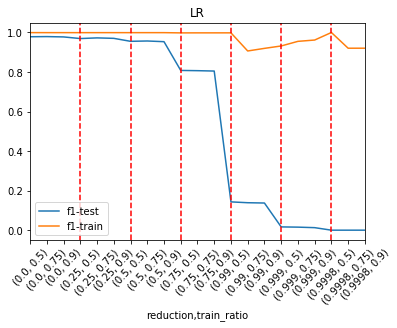

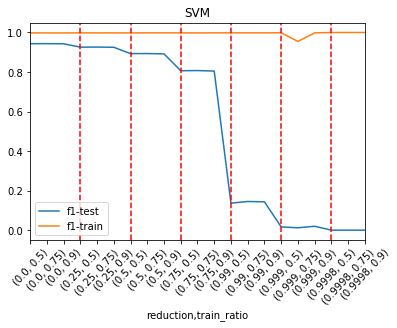

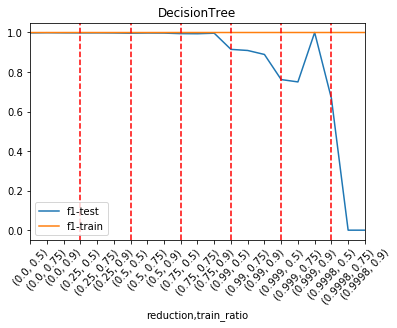

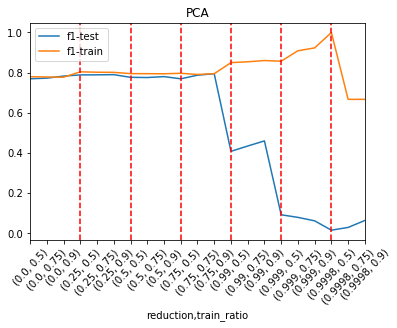

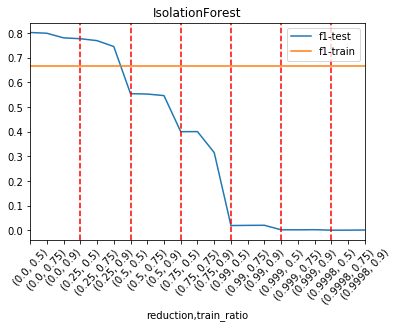

In [208]:
import matplotlib.pyplot as plt
%matplotlib inline

train_ratios = [0.5, 0.75, 0.9]
percentages = [0.0, 0.25, 0.50, 0.75, 0.99, 0.999, 0.9998]
xticks = [str((x,y)) for x in percentages for y in train_ratios]

results = pd.concat(dfs)
results['model_name'] = results['model'].apply(lambda x : type(x).__name__)
results.replace('HDFS', '0', inplace=True)

for model in supervised + unsupervised + semi_supervised:
    results[results.model_name == model].groupby(['reduction', 'train_ratio']).agg(np.mean).plot()
    for i in range(3, 19, 3):
        _ = plt.axvline(x=i,color='r', linestyle='--')
    _ = plt.xticks(range(len(xticks)), labels=xticks, rotation=47)
    plt.title(model)

## Previous results

In [109]:
experience_1 = pd.concat(dfs)

In [192]:
experience_2 = pd.concat(dfs)